In [1]:
import sys
sys.path.append("../src/")

In [22]:
import importlib
from typing import Dict, Literal, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import anomaly_detector.model_factory as model_factory
import torch
from anomaly_detector.models.pengwu_net import PengWuNet
from anomaly_detector.models.sultani_net import SultaniNet
from anomaly_detector.models.svm_baseline import BaselineNet

In [5]:
def load_backbone(
    feature_name: Literal["C3D", "I3D", "Video Swin"],
    device: torch.device,
    crop_type: Literal["10-crop", "5-crop", "center"] = "5-crop",
) -> Tuple[torch.nn.Module, torch.nn.Module, torch.nn.Module, Dict[str, int]]:
    if feature_name == "C3D":
        backbone_module = importlib.import_module("feature_extractor.models.c3d_sports1m-pretrained_8xb30-16x1x1-45e_ucf101-rgb")
    elif feature_name == "I3D":
        backbone_module = importlib.import_module(
            "feature_extractor.models.i3d_imagenet-pretrained-r50-nl-dot-product_8xb8-32x2x1-100e_kinetics400-rgb"
        )
    elif feature_name == "Video Swin":
        backbone_module = importlib.import_module("feature_extractor.models.swin-tiny-p244-w877_in1k-pre_8xb8-amp-32x2x1-30e_kinetics400-rgb")
    else:
        raise ValueError(f"Unsupported feature_name={feature_name}")

    backbone = backbone_module.build_model().to(device)
    preprocess_video = backbone_module.build_video2clips_pipeline(batch_size=1, io_backend="local", id_key="id", path_key="path", num_clips=-1)
    preprocess_clip = backbone_module.build_clip_pipeline(crop_type=crop_type)
    sampling_strategy = {
        "clip_len": backbone_module.preprocessing_cfg["clip_len"],
        "sampling_rate": backbone_module.preprocessing_cfg["sampling_rate"],
    }

    return backbone, preprocess_video, preprocess_clip, sampling_strategy

In [6]:
def load_detector(
    model_name: Literal["HL-Net", "Sultani-Net", "SVM Baseline"],
    feature_name: Literal["C3D", "I3D", "Video Swin"],
    ckpt_type: Literal["Best", "Last"],
    device: torch.device,
) -> Union[PengWuNet, SultaniNet, BaselineNet]:
    model = model_factory.build_model(model_name, feature_name, ckpt_type).to(device)

    return model

In [7]:
def predict_pipeline(
    clip_dict: Dict[str, torch.Tensor],
    backbone: torch.nn.Module,
    detector: Union[PengWuNet, SultaniNet, BaselineNet],
    device: torch.device,
) -> float:
    assert "inputs" in clip_dict, "clip_dict must contain 'inputs' key"

    if isinstance(detector, PengWuNet):  # PengWuNet: (B, T=1, D) -> (B, T=1, 1)
        clip_in = clip_dict["inputs"].squeeze(0).to(device)
        with torch.no_grad():
            clip_emb = backbone(clip_in)  # (B, D)
            clip_emb = clip_emb.unsqueeze(1)  # (B, 1, D) # PengWuNet expects (B, T, D) where T=1 for online inference
            clip_score = detector.predict(inputs=clip_emb, online=True)  # (B, T=1, 1)
            clip_score = torch.mean(clip_score).cpu().numpy()  # (1,)
        return clip_score.item()

    elif isinstance(detector, SultaniNet) or isinstance(detector, BaselineNet):
        clip_in = clip_dict["inputs"].squeeze(0).to(device)
        with torch.no_grad():
            clip_emb = backbone(clip_in)  # (B, D)
            clip_score = detector.predict(inputs=clip_emb)  # (B, 1)
            clip_score = torch.mean(clip_score).cpu().numpy()
        return clip_score.item()

    else:
        raise ValueError(f"Unknown detector type {type(detector)}")

In [8]:
backbone, preprocess_video, preprocess_clip, sampling_strategy = load_backbone("I3D", torch.device("cuda"), crop_type="5-crop")
detector = load_detector("Sultani-Net", "I3D", "Best", torch.device("cuda"))

c:\Users\Jia Herng\miniconda3\envs\fyp-env\lib\site-packages\mmcv\cnn\bricks\transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv`` rather than ``mmcv-lite`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [47]:
anomaly_path = "v=DRGMajXo_PI__#00-02-15_00-03-02_label_G-0-0.mp4"
normal_path = "v=QiLNvC7CIuY__#1_label_A.mp4"
anomaly_path2 = "Saving.Private.Ryan.1998__#02-24-18_02-25-42_label_B1-0-0.mp4"

In [18]:
anomaly_clip_res = []
clip_iter = preprocess_video({"id": anomaly_path, "path": anomaly_path})
for i, clip_dict in enumerate(clip_iter):
    clip_dict = preprocess_clip(clip_dict)
    clip_score = predict_pipeline(clip_dict, backbone, detector, torch.device("cuda"))
    print(f"Clip {i}: {clip_score}")
    anomaly_clip_res.append(clip_score)

Clip 0: 0.6848118901252747
Clip 1: 0.6947149634361267
Clip 2: 7.362494943663478e-05
Clip 3: 6.230231065273983e-06
Clip 4: 0.012349477969110012
Clip 5: 0.6263216137886047
Clip 6: 0.693761944770813
Clip 7: 0.9816814661026001
Clip 8: 0.5868366360664368
Clip 9: 0.11337833851575851
Clip 10: 0.2809444069862366
Clip 11: 0.22562959790229797
Clip 12: 0.08436606079339981
Clip 13: 0.17413616180419922
Clip 14: 0.8633610010147095
Clip 15: 0.4263845384120941
Clip 16: 0.9982184767723083
Clip 17: 0.8050944209098816


In [14]:
normal_clip_res = []
clip_iter = preprocess_video({"id": normal_path, "path": normal_path})
for i, clip_dict in enumerate(clip_iter):
    clip_dict = preprocess_clip(clip_dict)
    clip_score = predict_pipeline(clip_dict, backbone, detector, torch.device("cuda"))
    print(f"Clip {i}: {clip_score}")
    normal_clip_res.append(clip_score)

Clip 0: 2.2647019193300366e-07
Clip 1: 1.0134736072586747e-07
Clip 2: 7.738142071556098e-11
Clip 3: 3.4390136571804675e-11
Clip 4: 5.594321006441305e-09
Clip 5: 3.3999889570424102e-09
Clip 6: 7.311129479603551e-10
Clip 7: 6.047668588138322e-09
Clip 8: 9.483779983554541e-09
Clip 9: 1.1641690207397914e-06
Clip 10: 4.1379554005516184e-08
Clip 11: 1.205597612852216e-07
Clip 12: 4.1506208958708157e-07
Clip 13: 2.964621437229198e-08
Clip 14: 5.120386603607585e-08
Clip 15: 3.980592211405565e-08
Clip 16: 8.974765819402819e-08
Clip 17: 1.5969112610036973e-07
Clip 18: 2.256654988741502e-05


In [48]:
anomaly_clip_res2 = []
clip_iter = preprocess_video({"id": anomaly_path2, "path": anomaly_path2})
for i, clip_dict in enumerate(clip_iter):
    clip_dict = preprocess_clip(clip_dict)
    clip_score = predict_pipeline(clip_dict, backbone, detector, torch.device("cuda"))
    print(f"Clip {i}: {clip_score}")
    anomaly_clip_res2.append(clip_score)

Clip 0: 0.0001532469759695232
Clip 1: 0.006095613818615675
Clip 2: 0.9091712236404419
Clip 3: 0.9987491965293884
Clip 4: 0.2642535865306854
Clip 5: 0.022303955629467964
Clip 6: 1.1177075265322856e-07
Clip 7: 2.2501180865219794e-06
Clip 8: 4.2243216739734635e-05
Clip 9: 0.025902975350618362
Clip 10: 0.2996910512447357
Clip 11: 0.5189422369003296
Clip 12: 0.8314023017883301
Clip 13: 5.132756086823065e-08
Clip 14: 4.140340958969091e-09
Clip 15: 1.1585087333898514e-09
Clip 16: 2.7258911572403122e-08
Clip 17: 2.2760083083994687e-05
Clip 18: 0.006895479746162891
Clip 19: 0.00023181324650067836
Clip 20: 1.0906238458119333e-05
Clip 21: 0.0021289230789989233
Clip 22: 0.014131610281765461
Clip 23: 0.0008183843456208706
Clip 24: 8.947802712100383e-07
Clip 25: 0.000306151807308197
Clip 26: 0.01742521859705448
Clip 27: 0.009136121720075607
Clip 28: 1.3456905435305089e-05
Clip 29: 0.00025699014076963067
Clip 30: 8.475123649986926e-06
Clip 31: 6.733785994583741e-06


In [49]:
anomaly_ann = [0, 1111]
normal_ann = []
anomaly_ann2 = [72, 428, 550, 830, 1085, 2016]

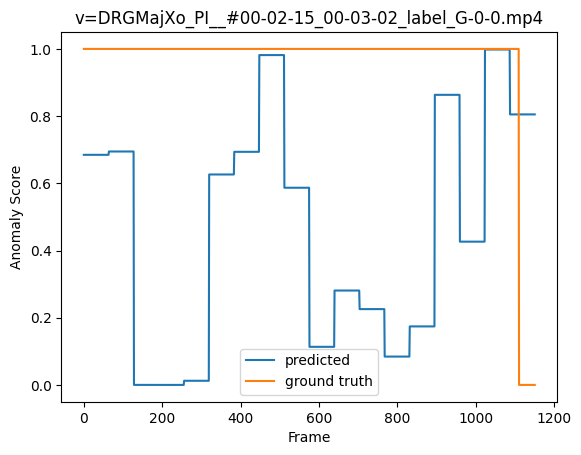

In [46]:
extrapolate_anomaly_clip_res = np.array(anomaly_clip_res).repeat(sampling_strategy["sampling_rate"] * sampling_strategy["clip_len"])
anomaly_frames = np.arange(0, len(extrapolate_anomaly_clip_res))
anomaly_frames_labels = np.zeros_like(anomaly_frames)
anomaly_frames_labels[anomaly_ann[0]:anomaly_ann[1]] = 1


plt.plot(extrapolate_anomaly_clip_res, label="predicted")
plt.plot(anomaly_frames, anomaly_frames_labels, label="ground truth")
plt.title(anomaly_path)
plt.xlabel("Frame")
plt.ylabel("Anomaly Score")
plt.legend()


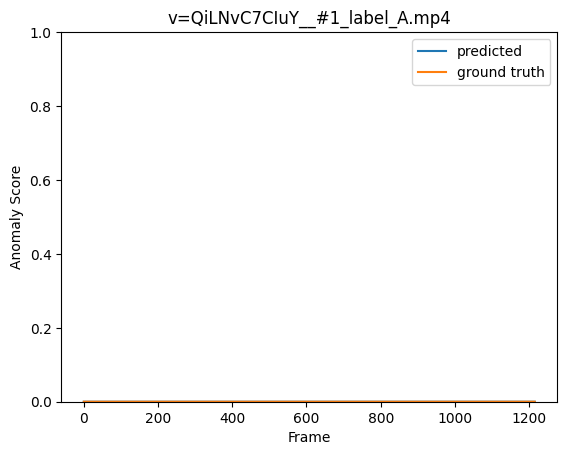

In [54]:
extrapolate_normal_clip_res = np.array(normal_clip_res).repeat(sampling_strategy["sampling_rate"] * sampling_strategy["clip_len"])
normal_frames = np.arange(0, len(extrapolate_normal_clip_res))
normal_frames_labels = np.zeros_like(normal_frames)

plt.plot(extrapolate_normal_clip_res, label="predicted")
plt.plot(normal_frames, normal_frames_labels, label="ground truth")
plt.title(normal_path)
plt.xlabel("Frame")
plt.ylabel("Anomaly Score")
plt.ylim((0, 1))
plt.legend()
plt.show()

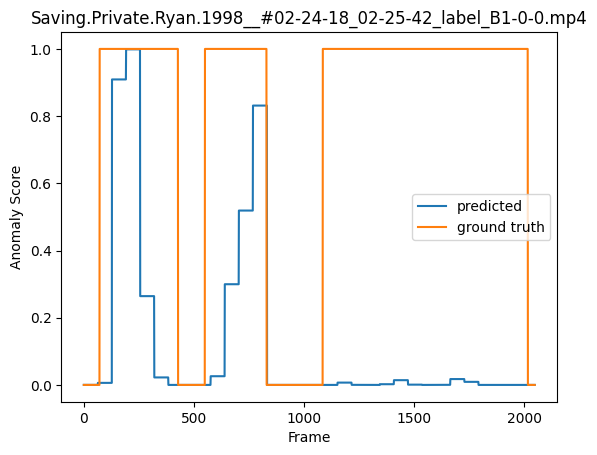

In [52]:
extrapolate_anomaly_clip_res2 = np.array(anomaly_clip_res2).repeat(sampling_strategy["sampling_rate"] * sampling_strategy["clip_len"])
anomaly_frames2 = np.arange(0, len(extrapolate_anomaly_clip_res2))
anomaly_frames_labels2 = np.zeros_like(anomaly_frames2)
anomaly_frames_labels2[anomaly_ann2[0]: anomaly_ann2[1]] = 1
anomaly_frames_labels2[anomaly_ann2[2]: anomaly_ann2[3]] = 1
anomaly_frames_labels2[anomaly_ann2[4]: anomaly_ann2[5]] = 1

plt.plot(extrapolate_anomaly_clip_res2, label="predicted")
plt.plot(anomaly_frames2, anomaly_frames_labels2, label="ground truth")
plt.title(anomaly_path2)
plt.xlabel("Frame")
plt.ylabel("Anomaly Score")
plt.legend()
